In [61]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

In [87]:
###Repeaters data from Chime catalog
with open('./catalog/repeaters.txt') as json_file:
    repeaters = json.load(json_file)

chime_repeaters={'source':[],'n_bursts':[], 'flux':[]}
ra_dec=[[],[]]
for source in repeaters:
    ra_dec[0].append(repeaters[source]['ra']['value'])
    ra_dec[1].append(repeaters[source]['dec']['value'])
    count=0
    for key in repeaters[source]:
        if key != 'dm' and key !='ymw16' and key!='dec' and key!='gl' and key!='gb' and key!= 'ra' and \
            key!='localized' and key!='last_burst_date' and key!='publication' and key!='ne2001' and \
            key!='previous_name': 
            count+=1
            if repeaters[source][key]['flux']['value'] != {}: 
                chime_repeaters['flux'].append(repeaters[source][key]['flux']['value'])
    if source=='190907.J08+46': chime_repeaters['source'].append('FRB'+source)
    else:chime_repeaters['source'].append(source)
    chime_repeaters['n_bursts'].append(count)
    
#source and number data, coordinates for each burst
chime_repeaters_coord=SkyCoord(ra=ra_dec[0], dec=ra_dec[1], unit=(u.hourangle, u.deg))

#mjd array for repeater bursts
rep_utc=[]
for source in repeaters:
    for event in repeaters[source].keys():
        if 'timestamp' in repeaters[source][event].keys():
            rep_utc.append(repeaters[source][event]['timestamp']['value'])
            
chime_repeaters_srcs={'src':[],'ra_deg':[],'dec_deg':[],'mjd':[]}
for i in range(len(chime_repeaters['source'])):
    brst=[chime_repeaters['source'][i]]*chime_repeaters['n_bursts'][i]
    [chime_repeaters_srcs['src'].append(b) for b in brst]
    ra=[chime_repeaters_coord[i].ra.deg]*chime_repeaters['n_bursts'][i]
    [chime_repeaters_srcs['ra_deg'].append(c) for c in ra]
    dec=[chime_repeaters_coord[i].dec.deg]*chime_repeaters['n_bursts'][i]
    [chime_repeaters_srcs['dec_deg'].append(c) for c in dec]
chime_repeaters_srcs['mjd'] = np.asarray([Time(t, format='iso').mjd for t in rep_utc])

chime_rep=pd.DataFrame.from_dict(data=chime_repeaters_srcs) #save as data frame

In [63]:
###FRBCat
frbcat = pd.read_csv('./catalog/frbcat_20210519_all.csv')

#CHIME repeaters: remove repeaters from FRBCat to not double-count events
chimes=np.where(frbcat['telescope']=='CHIME/FRB')
frbcheck=[] #names from frbcat
for n in chimes[0]:
    frbcheck.append(frbcat['frb_name'][n][0:9])
    
frbcat_format=''
rem=[[],[]]
for source in chime_repeaters['source']:
    if source[0:3]=='FRB':
        frbcat_format=source[0:3]+source[5:-1]
    else:
        frbcat_format='FRB'+source[0:6]
    
    res = any(ele in frbcat_format for ele in frbcheck)
    if bool(res) == 1:
        rem[0].append(frbcheck[frbcheck.index(frbcat_format)])
    
for ind in range(len(frbcat['frb_name'])):
    res = any(ele in frbcat['frb_name'][ind] for ele in rem[0])
    if bool(res)==1:
        rem[1].append(ind)
frbcat=frbcat.drop(rem[1])

frbs_mjd = np.asarray([Time(t.replace('/', '-'), format='iso').mjd for t in frbcat['utc']]) 
frbs_coord = SkyCoord(ra=frbcat['rop_raj'], dec=frbcat['rop_decj'],unit=(u.hourangle, u.deg))

In [64]:
### Chime catalog 1
chime_cat1 = pd.read_csv('./catalog/chimefrbcat1.csv')

cat1_times=[Time('2018-07-25 00:00:00', format='iso').mjd, Time('2019-07-01 00:00:00', format='iso').mjd]

remove_rep_duplicates=[]
for i in range(len(chime_cat1['repeater_name'])):
    name=chime_cat1['repeater_name'][i]
    if chime_cat1['previous_name'][i]== '190907.J08+46' or chime_cat1['previous_name'][i]== 'FRB121102':
        chime_cat1['tns_name'][i]=chime_cat1['previous_name'][i]
    if chime_cat1['tns_name'][i] in chime_repeaters['source']:
        if chime_cat1['mjd_400'][i]>cat1_times[0] and chime_cat1['mjd_400'][i]<cat1_times[1]:
            remove_rep_duplicates.append(i)
            
chime_cat1=chime_cat1.drop(remove_rep_duplicates)

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [65]:
#combined DataFrame for all catalogs
#repeater is a bool array: True=rep, False=single burst
frbs_all = {'src':[], 'ra_deg':[],'dec_deg':[],'mjd':[],'repeater':[]} 

[frbs_all['src'].append(name_f) for name_f in frbcat['frb_name']]
[frbs_all['src'].append(name_c) for name_c in chime_cat1['tns_name']]
[frbs_all['src'].append(name_r) for name_r in chime_repeaters_srcs['src']]

[frbs_all['ra_deg'].append(ra_f) for ra_f in frbs_coord.ra.deg]
[frbs_all['ra_deg'].append(ra_c) for ra_c in chime_cat1['ra']]
[frbs_all['ra_deg'].append(ra_r) for ra_r in chime_repeaters_srcs['ra_deg']]

[frbs_all['dec_deg'].append(dec_f) for dec_f in frbs_coord.dec.deg]
[frbs_all['dec_deg'].append(dec_c) for dec_c in chime_cat1['dec']]
[frbs_all['dec_deg'].append(dec_r) for dec_r in chime_repeaters_srcs['dec_deg']]

[frbs_all['mjd'].append(mjd_f) for mjd_f in frbs_mjd]
[frbs_all['mjd'].append(mjd_c) for mjd_c in chime_cat1['mjd_400']]
[frbs_all['mjd'].append(mjd_r) for mjd_r in chime_repeaters_srcs['mjd']]

#creating repeater bool array: True=repeater, False=non-repeater
unique_frbs, ind, n_frbs = np.unique(frbcat['frb_name'].values, return_counts=True, return_index=True)
msk=n_frbs==1
non_rep=frbcat['frb_name'][frbcat['frb_name'].index[np.sort(ind[msk])]].values
for name in frbcat['frb_name']: 
    if name in non_rep: frbs_all['repeater'].append(False)
    else: frbs_all['repeater'].append(True)
        
unique_frbs, ind, n_frbs = np.unique(chime_cat1['tns_name'].values, return_counts=True, return_index=True)
msk=n_frbs==1
non_rep=chime_cat1['tns_name'][chime_cat1['tns_name'].index[np.sort(ind[msk])]].values
for name in chime_cat1['tns_name']: 
    if name in non_rep: frbs_all['repeater'].append(False)
    else: frbs_all['repeater'].append(True)
        
[frbs_all['repeater'].append(True) for i in range(len(chime_repeaters_srcs['src']))]

frbs_all_data=pd.DataFrame.from_dict(data=frbs_all)
frbs_all_data.to_csv('./catalog/frbs_all.csv',index=False)

### Plots of FRB data

In [66]:
rep=np.where(frbs_all['repeater'])[0]
non_rep=np.where(np.where(frbs_all['repeater'],False,True))[0]
unique_repeaters=np.unique([frbs_all['src'][i] for i in rep])

In [67]:
print('       |sources | repeaters | bursts | events')
frbcat_unique, n_unique_frbcat=np.unique(frbcat['frb_name'], return_counts=True)
print('frbcat      | %i   | %i  | %i  | %i '%(len(frbcat_unique), 
                                        len(np.where(n_unique_frbcat!=1)[0]),
                                        len(frbcat['frb_name'])-len(np.where(n_unique_frbcat==1)[0]),
                                        len(frbcat['frb_name'])))
chimerep_unique, n_unique_chimerep=np.unique(chime_repeaters_srcs['src'], return_counts=True)
print('chime rep   | %i   | %i | %i | %i '%(len(chimerep_unique), 
                                        len(np.where(n_unique_chimerep!=1)[0]),
                                        len(chime_repeaters_srcs['src'])-len(np.where(n_unique_chimerep==1)[0]),
                                        len(chime_repeaters_srcs['src'])))
chime_cat1_unique, n_unique_chime=np.unique(chime_cat1['tns_name'], return_counts=True)
print('chime cat1  | %i  | %i | %i | %i '%(len(chime_cat1_unique), 
                                        len(np.where(n_unique_chime!=1)[0]),
                                        len(chime_cat1['tns_name'])-len(np.where(n_unique_chime==1)[0]),
                                        len(chime_cat1['tns_name'])))
print('total       | %i  | %i | %i | %i '%(len(frbcat_unique)+len(chimerep_unique)+len(chime_cat1_unique), 
                                           len(np.where(n_unique_frbcat!=1)[0])+len(np.where(n_unique_chimerep!=1)[0])+
                                           len(np.where(n_unique_chime!=1)[0]),
                                           len(rep), len(frbs_all['src'])))
print('-----------------------------')
print('6yr    | 13  | 1  | 17  | 29 ')
print('L2     | 29  | 1  | 10  | 39 ')

       |sources | repeaters | bursts | events
frbcat      | 99   | 4  | 26  | 121 
chime rep   | 18   | 18 | 172 | 172 
chime cat1  | 518  | 40 | 100 | 578 
total       | 635  | 62 | 298 | 871 
-----------------------------
6yr    | 13  | 1  | 17  | 29 
L2     | 29  | 1  | 10  | 39 


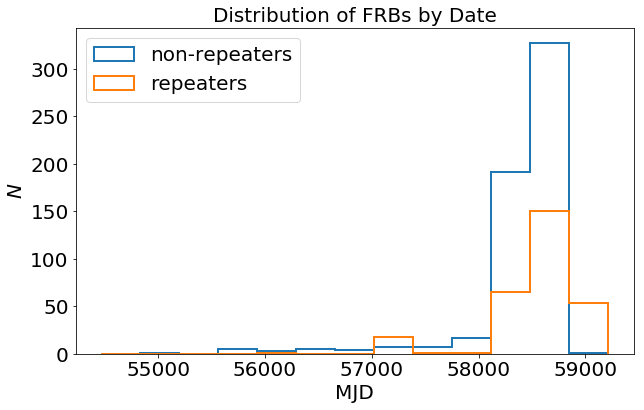

In [68]:
#dates histogram
year_bins = [Time(f'20{year:02d}-01-01 00:00:00', format='iso').mjd for year in range(8, 22)]

fig, ax = plt.subplots(figsize=(10,6))
plt.hist([frbs_all['mjd'][i] for i in non_rep], bins=year_bins, histtype='step', lw=2., label='non-repeaters')
plt.hist([frbs_all['mjd'][i] for i in rep], bins=year_bins, histtype='step', lw=2., label='repeaters')

plt.legend(loc=2)
plt.xlabel('MJD')
plt.ylabel(r'$N$')
ax.set_title(r'Distribution of FRBs by Date', fontsize=20)
plt.savefig('./frb_param_plots/date_distr.png')

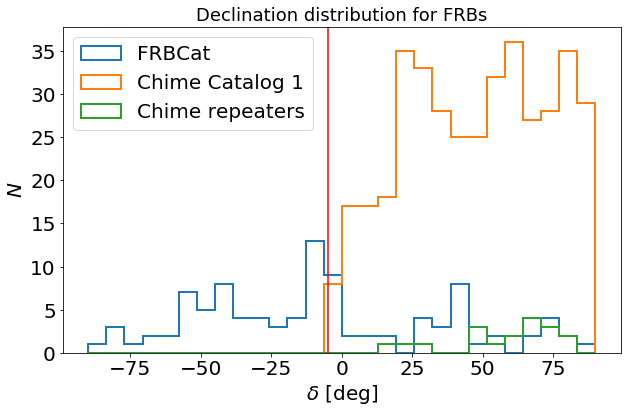

In [71]:
#declination histogram
fig, ax = plt.subplots(figsize=(10,6))
dec_bins = np.linspace(-90,90,num=29) #every 10 deg

plt.hist(np.unique(frbs_coord.dec.deg), bins=dec_bins, histtype='step', lw=2., label='FRBCat')
plt.hist(np.unique(chime_cat1['dec']), bins=dec_bins, histtype='step', lw=2., label='Chime Catalog 1')
plt.hist(np.unique(chime_repeaters_srcs['dec_deg']),bins=dec_bins, histtype='step', lw=2., label='Chime repeaters')

plt.legend(loc=2)
plt.axvline(x=-5, c='red')
ax.set_title(r'Declination distribution for FRBs', fontsize=18)
plt.xlabel(r'$\delta$ [deg]')
plt.ylabel(r'$N$')
plt.savefig('./frb_param_plots/dec_distr.png')

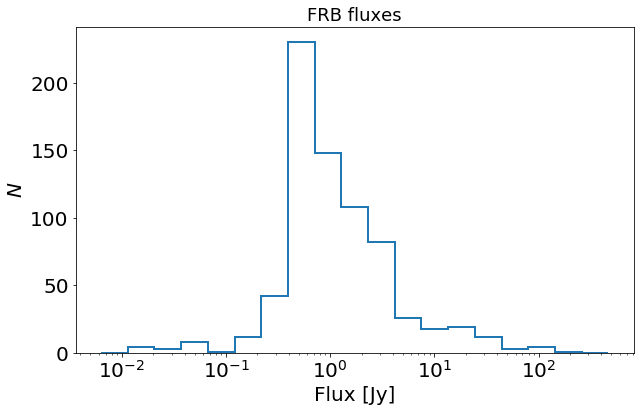

In [122]:
# flux histogram
all_fluxes=np.concatenate((frbcat['rmp_flux'][~np.isnan(frbcat['rmp_flux'])].values, 
            chime_cat1['flux'].values, chime_repeaters['flux']))
all_fluxes=all_fluxes[np.where(all_fluxes>0)[0]]
flux_bins=np.logspace(np.log(min(all_fluxes))/np.log(10)-0.5, np.log(max(all_fluxes))/np.log(10)+0.5, num=20)
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(all_fluxes, bins=flux_bins, histtype='step', lw=2., label='FRB')

plt.ylabel(r'$N$')
plt.semilogx()
plt.xlabel(r'Flux [Jy]')
ax.set_title(r'FRB fluxes', fontsize=18)
plt.savefig('./frb_param_plots/flux_distr.png')